In [1]:
import os
import random

import tensorflow as tf      # Deep Learning library
import numpy as np           # Handle matrices
import retro                 # Retro Environment
from retro.retro_env import RetroEnv

import matplotlib.pyplot as plt # Display graphs
from IPython import display

from collections import deque # Ordered collection with ends

import gym



rom_path = os.path.dirname(os.path.abspath('.')) + '/StreetFighterIISpecialChampionEdition-Genesis'

#scenario_name = 'scenario_sunppang'
scenario_name = 'scenario'

model_path = '/root/sf2-workspace/sf2-env/sf2/models/sunppang_small_network_64nodes_2000_episodes/model.ckpt'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
#log_file = open('./dqn.log', 'w')

### PREPROCESSING HYPERPARAMETERS
#stack_size = 10                 # Number of frames stacked
stack_size = 5
state_element_number = 27

# x축 거리(0~187), y축 거리(0~70), 좌(상대편의 왼쪽), 우(상대편의 오른쪽) (장풍은 제거, TODO: 장풍 state 추가, 공격 범위 추가)
state_size = state_element_number * stack_size
#learning_rate =  0.00025
#learning_rate =  0.0005
learning_rate = 0.005

### TRAINING 관련
total_episodes = 1000            
max_steps = 50000              
batch_size = 64
#batch_size = 1000

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
#decay_rate = 0.00001           # exponential decay rate for exploration prob
decay_rate = 0.00001           # exponential decay rate for exploration prob

# Q learning hyperparameters
#gamma = 0.9                    # Discounting rate
gamma = 0.95

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
#memory_size = 1000000          # Number of experiences the Memory can keep
memory_size = 100000

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False




In [2]:



class SF2Env(RetroEnv):
    KEY_LIST = ["B", "A", "MODE", "START", "UP", "DOWN", "LEFT", "RIGHT", "C", "Y", "X", "Z"]
    
    
    
    def __init__(self, game, state=retro.State.DEFAULT, scenario=None, info=None, use_restricted_actions=retro.Actions.FILTERED,
                 record=False, players=1, inttype=retro.data.Integrations.STABLE, obs_type=retro.Observations.IMAGE, press_button_print=False):
        self.recent_action = None
        
        # action 입력은 DISCRETE 모드
        use_restricted_actions = retro.Actions.DISCRETE
        self.press_button_print = press_button_print
        
        RetroEnv.__init__(self, game, state, scenario, info, use_restricted_actions,
                 record, players, inttype, obs_type)
        self.buttons = ["B", "A", "MODE", "START", "UP", "DOWN", "LEFT", "RIGHT", "C", "Y", "X", "Z"]
        self.buttons_dict = {}
        for k,v in enumerate(self.buttons):
            self.buttons_dict[v] = k
        
        self.actions = [
            ['LEFT'],
            ['RIGHT'],
            ['UP'],
            ['DOWN'],
            ['LEFT','UP'],
            ['LEFT', 'DOWN'],
            ['RIGHT', 'UP'],
            ['RIGHT', 'DOWN'],
            ['A'],
            ['B'],
            ['C'],
            ['X'],
            ['Y'],
            ['Z'],
            ['DOWN', 'A'],
            ['DOWN', 'B'],
            ['DOWN', 'C'],
            ['DOWN', 'X'],
            ['DOWN', 'Y'],
            ['DOWN', 'Z']
        ]
        
        self.action_space = gym.spaces.Discrete(len(self.actions) ** players)
    
    def step(self, a):
        self.recent_action = a
        reward_sum = 0
        for i in range(5):
            ob, rew, done, info = RetroEnv.step(self, a)
            reward_sum += rew
        
        if self.press_button_print:
            print(self.action_array_to_keys(self.action_to_array(a)))
        
        return self.get_state_from(), reward_sum, done, info
    
    def reset(self):
        RetroEnv.reset(self)
        self.recent_action = None
        return self.get_state_from()
            
    def action_array_to_keys(self, action_array):
        press_keys = []
        for i,v in enumerate(action_array[0]):
            if v == 1:
                press_keys.append(self.KEY_LIST[i])
        return press_keys
    
    def action_to_array(self, a):
        button_array = [0] * 12
        for button in self.actions[a]:
            button_array[self.buttons_dict[button]] = 1
        return [button_array]
        
    
    # env로부터 state 값을 변환
    def get_state_from(self):
        state = []
        
        is_1p_atackking = 1 if int(self.data.lookup_value('is_first_player_atackking')) in [1, 513, 1537] else 0
        is_2p_atackking = 1 if int(self.data.lookup_value('is_second_player_atackking')) in [1, 513, 1537] else 0
        
        is_1p_jumping = 1 if int(self.data.lookup_value('first_player_y')) > 192 else 0
        is_2p_jumping = 1 if int(self.data.lookup_value('second_player_y')) > 192 else 0
        
        first_player_x = int(self.data.lookup_value('first_player_x'))
        second_player_x = int(self.data.lookup_value('second_player_x'))
        left_or_right = 0
        left_or_right = 1 if first_player_x > second_player_x else 0
        if first_player_x > second_player_x:
            left_or_right = 1
        elif first_player_x < second_player_x: 
            left_or_right = -1
        else:
            left_or_right = 0
        
        state.append(int(self.data.lookup_value('distance_x_between_players'))/188)
        state.append(int(self.data.lookup_value('distance_y_between_players'))/71)
        
        #state.append(int(self.data.lookup_value('first_player_attack_x')))
        #state.append(int(self.data.lookup_value('second_player_attack_x')))
        
        state.append(is_1p_jumping)
        state.append(is_2p_jumping)
        
        
        state.append(is_1p_atackking)
        state.append(is_2p_atackking)
        
        state.append(left_or_right)
        
        #state.append(int(self.data.lookup_value('is_first_player_jangpoong')))
        #state.append(int(self.data.lookup_value('is_first_player_jangpoong_x')))
        #state.append(int(self.data.lookup_value('is_first_player_jangpoong_y')))
        
        #state.append(int(self.data.lookup_value('is_second_player_jangpoong')))
        #state.append(int(self.data.lookup_value('is_second_player_jangpoong_x')))
        #state.append(int(self.data.lookup_value('is_second_player_jangpoong_y')))
        
        #state.append(int(self.data.lookup_value('continuetimer'))/153) # max 153
        #state.append(int(self.data.lookup_value('first_player_health'))) # range : -1 ~ 176
        #state.append(int(self.data.lookup_value('second_player_health')))
        #state.append(int(self.data.lookup_value('first_player_action_kind')))
        
        # 에이전트의 최근 액션 (20개)
        for j in range(len(self.actions)):
            if self.recent_action == j:
                state.append(1)
            else:
                state.append(0)
        
        return np.asarray(state)


env = SF2Env(rom_path, 
             state='rvsb.state', 
             scenario=scenario_name,
             press_button_print=False)


possible_actions = np.array(list(range(0, env.action_space.n)))





# initialize (deque 사용, max 4개 유지)
#stacked_frames  =  deque([np.zeros(188*71+2, dtype=np.int) for i in range(stack_size)], maxlen=4)
stacked_frames  =  deque([np.zeros(state_element_number, dtype=np.int) for i in range(stack_size)], maxlen=stack_size)

def stack_frames(stacked_frames, state, is_new_episode):
    frame = state
    
    if is_new_episode:
        # clear stacked_frames
        stacked_frames = deque([np.zeros(state_element_number, dtype=np.int) for i in range(stack_size)], maxlen=stack_size)
        
        for i in range(stack_size-1):
            stacked_frames.append(frame)
        
        stacked_state = np.stack(stacked_frames, axis=1)
        
    else:
        stacked_frames.append(frame)
        
        stacked_state = np.stack(stacked_frames) 
    
    return stacked_state, stacked_frames





class DQNetwork:
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        with tf.variable_scope(name):
            # We create the placeholders
            # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
            # [None, 84, 84, 4]
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.float32, [None, self.action_size], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            self.fc = tf.layers.dense(inputs = self.inputs_,
                                  units = 64,
                                  activation = tf.nn.elu,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="fc")
            
            '''
            self.fc2 = tf.layers.dense(inputs = self.fc,
                                  units = 40,
                                  activation = tf.nn.elu,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="fc2")
            '''
            
            self.output = tf.layers.dense(inputs = self.fc, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          units = self.action_size, 
                                        activation=None)
  
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_))
            
            # The loss is the difference between our predicted Q_values and the Q_target
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

            
# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DQNetwork(state_size, env.action_space.n, learning_rate)




class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)
        
        return [self.buffer[i] for i in index]



# Instantiate memory
memory = Memory(max_size = memory_size)
for i in range(pretrain_length):
    # If it's the first step
    if i == 0:
        state = env.reset()
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        state = state.flatten()
        
    action = random.randint(0, env.action_space.n - 1)
    next_state, reward, done, _ = env.step(action)
    
    #env.render()
    
    # Stack the frames
    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
    next_state = next_state.flatten()
    
    # If the episode is finished (we're dead 3x)
    if done:
        # We finished the episode
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        
        memory.add((state, action, reward, next_state, done))
        
        # Start a new episode
        state = env.reset()
        
        # Stack the frames
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        state = state.flatten()
        
        
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Our new state is now the next_state
        state = next_state


# Setup TensorBoard Writer
tb_path = os.path.dirname(os.path.abspath('.')) + '/tensorboard/dqn/small_space'

writer = tf.summary.FileWriter(tb_path)

## Losses
tf.summary.scalar("Loss", DQNetwork.loss)

write_op = tf.summary.merge_all()




"""
This function will do the part
With ϵϵ select a random action atat, otherwise select at=argmaxaQ(st,a)
"""
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, actions):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()

    # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
    
    if (explore_probability > exp_exp_tradeoff):
        # Make a random action (exploration)
        choice = random.randint(1,len(possible_actions))-1
        action = possible_actions[choice]
        
    else:
        # Get action from Q-network (exploitation)
        # Estimate the Qs values state
        Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})
        
        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)
        action = possible_actions[choice]
                
                
    return action, explore_probability


# Saver will help us to save our model
saver = tf.train.Saver()
training = True
episode_render = False



if training == True:
    with tf.Session() as sess:
        # Initialize the variables
        sess.run(tf.global_variables_initializer())

        # Initialize the decay rate (that will use to reduce epsilon) 
        decay_step = 0
        
        for episode in range(total_episodes):
            # Set step to 0
            step = 0
            
            # Initialize the rewards of the episode
            episode_rewards = []
            
            # Make a new episode and observe the first state
            state = env.reset()
            
            # Remember that stack frame function also call our preprocess function.
            state, stacked_frames = stack_frames(stacked_frames, state, True)
            state = state.flatten()
            
            
            while step < max_steps:
                step += 1
                
                #Increase decay_step
                decay_step +=1
                
                # Predict the action to take and take it
                action, explore_probability = predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions)
                #print(action)
                
                #Perform the action and get the next_state, reward, and done information
                next_state, reward, done, _ = env.step(action)
                
                if episode_render and step % 100 == 0 :
                    plt.imshow(env.render(mode='rgb_array'))
                    plt.axis('off')
                    display.clear_output(wait=True)
                    display.display(plt.gcf())
                
                # Add the reward to total reward
                episode_rewards.append(reward)
                
                # If the game is finished
                if done:
                    # The episode ends so no next state
                    next_state = np.zeros(state_element_number, dtype=np.int)
                    
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                    next_state = next_state.flatten()

                    # Set step = max_steps to end the episode
                    step = max_steps

                    # Get the total reward of the episode
                    total_reward = np.sum(episode_rewards)
                    
                    if env.data.lookup_value('first_player_health') > env.data.lookup_value('second_player_health'):
                        episode_result = 'win'
                    else:
                        episode_result = 'lose'

                    result_str = '{' + '"episode":{}, "reward":{}, "explore": {:.4f}, "loss": {:.4f}, "result": "{}"'.format(episode+1, total_reward, explore_probability, loss, episode_result) + '}'
                    print(result_str)
                    #log_file.write(result_str + '\n')

                    #rewards_list.append((episode, total_reward))

                    # Store transition <st,at,rt+1,st+1> in memory D
                    memory.add((state, action, reward, next_state, done))

                else:
                    # Stack the frame of the next_state
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                    next_state = next_state.flatten()
                
                    # Add experience to memory
                    memory.add((state, action, reward, next_state, done))

                    # st+1 is now our current state
                    state = next_state
                    

                ### LEARNING PART            
                # Obtain random mini-batch from memory
                batch = memory.sample(batch_size)
                #print(np.array(batch).shape)
                states_mb = np.array([each[0] for each in batch], ndmin=1)
                #print(states_mb.shape)
                
                #actions_mb = np.array([each[1] for each in batch])
                list_agg = []
                for each in batch:
                    a_list = [0]*20
                    a_list[each[1]-1] = 1
                    list_agg.append(a_list)
                actions_mb = np.array(list_agg, ndmin=2)
                
                
                rewards_mb = np.array([each[2] for each in batch]) 
                next_states_mb = np.array([each[3] for each in batch], ndmin=1)
                dones_mb = np.array([each[4] for each in batch])

                target_Qs_batch = []

                # Get Q values for next_state 
                for i, v in enumerate(next_states_mb):
                    #if len(v) == 13350:
                    if len(v) == state_element_number:
                        print(i)
                
                
                Qs_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})
                
                # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma*maxQ(s', a')
                for i in range(0, len(batch)):
                    terminal = dones_mb[i]

                    # If we are in a terminal state, only equals reward
                    if terminal:
                        target_Qs_batch.append(rewards_mb[i])
                        
                    else:
                        target = rewards_mb[i] + gamma * np.max(Qs_next_state[i])
                        target_Qs_batch.append(target)
                        

                targets_mb = np.array([each for each in target_Qs_batch])

                loss, _ = sess.run([DQNetwork.loss, DQNetwork.optimizer],
                                        feed_dict={DQNetwork.inputs_: states_mb,
                                                   DQNetwork.target_Q: targets_mb,
                                                   DQNetwork.actions_: actions_mb})

                # Write TF Summaries
                summary = sess.run(write_op, feed_dict={DQNetwork.inputs_: states_mb,
                                                       DQNetwork.target_Q: targets_mb,
                                                       DQNetwork.actions_: actions_mb})
                writer.add_summary(summary, episode)
                writer.flush()

            # Save model every 5 episodes
            if episode % 5 == 4:
                save_path = saver.save(sess, model_path)
                print("Model Saved")
                
#log_file.close()
env.close()

{"episode":1, "reward":4.0, "explore": 0.9952, "loss": 66.8501, "result": "win"}
{"episode":2, "reward":-93.0, "explore": 0.9912, "loss": 21.3060, "result": "lose"}
{"episode":3, "reward":-6.0, "explore": 0.9859, "loss": 24.7216, "result": "lose"}
{"episode":4, "reward":-131.0, "explore": 0.9820, "loss": 0.0112, "result": "lose"}
{"episode":5, "reward":18.0, "explore": 0.9785, "loss": 0.4095, "result": "win"}
Model Saved
{"episode":6, "reward":-93.0, "explore": 0.9725, "loss": 4.8851, "result": "lose"}
{"episode":7, "reward":-176.0, "explore": 0.9713, "loss": 0.7833, "result": "lose"}
{"episode":8, "reward":-101.0, "explore": 0.9686, "loss": 14.3802, "result": "lose"}
{"episode":9, "reward":-37.0, "explore": 0.9626, "loss": 38.4252, "result": "lose"}
{"episode":10, "reward":-73.0, "explore": 0.9576, "loss": 22.2186, "result": "lose"}
Model Saved
{"episode":11, "reward":20.0, "explore": 0.9530, "loss": 31.8112, "result": "win"}
{"episode":12, "reward":-99.0, "explore": 0.9481, "loss": 1

{"episode":96, "reward":-159.0, "explore": 0.6497, "loss": 40.0288, "result": "lose"}
{"episode":97, "reward":-117.0, "explore": 0.6467, "loss": 37.3959, "result": "lose"}
{"episode":98, "reward":-96.0, "explore": 0.6428, "loss": 59.0340, "result": "lose"}
{"episode":99, "reward":-114.0, "explore": 0.6396, "loss": 59.9519, "result": "lose"}
{"episode":100, "reward":-41.0, "explore": 0.6359, "loss": 6.7635, "result": "lose"}
Model Saved
{"episode":101, "reward":75.0, "explore": 0.6330, "loss": 2.4881, "result": "win"}
{"episode":102, "reward":-84.0, "explore": 0.6296, "loss": 3.3224, "result": "lose"}
{"episode":103, "reward":-127.0, "explore": 0.6280, "loss": 32.7405, "result": "lose"}
{"episode":104, "reward":-84.0, "explore": 0.6251, "loss": 0.0661, "result": "lose"}
{"episode":105, "reward":-42.0, "explore": 0.6225, "loss": 39.7217, "result": "lose"}
Model Saved
{"episode":106, "reward":-140.0, "explore": 0.6203, "loss": 19.9024, "result": "lose"}
{"episode":107, "reward":-14.0, "ex

{"episode":189, "reward":-121.0, "explore": 0.4231, "loss": 1.8042, "result": "lose"}
{"episode":190, "reward":-81.0, "explore": 0.4214, "loss": 13.2931, "result": "lose"}
Model Saved
{"episode":191, "reward":-75.0, "explore": 0.4190, "loss": 56.7130, "result": "lose"}
{"episode":192, "reward":-72.0, "explore": 0.4169, "loss": 49.2708, "result": "lose"}
{"episode":193, "reward":-92.0, "explore": 0.4145, "loss": 32.4199, "result": "lose"}
{"episode":194, "reward":-148.0, "explore": 0.4133, "loss": 23.8020, "result": "lose"}
{"episode":195, "reward":-77.0, "explore": 0.4115, "loss": 46.6131, "result": "lose"}
Model Saved
{"episode":196, "reward":-128.0, "explore": 0.4094, "loss": 3.9325, "result": "lose"}
{"episode":197, "reward":23.0, "explore": 0.4074, "loss": 33.8856, "result": "win"}
{"episode":198, "reward":-96.0, "explore": 0.4065, "loss": 13.0223, "result": "lose"}
{"episode":199, "reward":-8.0, "explore": 0.4039, "loss": 0.1725, "result": "lose"}
{"episode":200, "reward":-163.0, 

{"episode":282, "reward":-64.0, "explore": 0.2873, "loss": 19.6068, "result": "lose"}
{"episode":283, "reward":-111.0, "explore": 0.2863, "loss": 65.4751, "result": "lose"}
{"episode":284, "reward":-158.0, "explore": 0.2856, "loss": 39.3681, "result": "lose"}
{"episode":285, "reward":-145.0, "explore": 0.2850, "loss": 60.0307, "result": "lose"}
Model Saved
{"episode":286, "reward":-164.0, "explore": 0.2841, "loss": 14.2540, "result": "lose"}
{"episode":287, "reward":-103.0, "explore": 0.2827, "loss": 21.5866, "result": "lose"}
{"episode":288, "reward":0.0, "explore": 0.2813, "loss": 40.1027, "result": "lose"}
{"episode":289, "reward":-110.0, "explore": 0.2796, "loss": 18.1727, "result": "lose"}
{"episode":290, "reward":27.0, "explore": 0.2776, "loss": 62.4869, "result": "win"}
Model Saved
{"episode":291, "reward":-166.0, "explore": 0.2769, "loss": 10.6727, "result": "lose"}
{"episode":292, "reward":-28.0, "explore": 0.2752, "loss": 15.2639, "result": "lose"}
{"episode":293, "reward":-3

{"episode":375, "reward":-171.0, "explore": 0.1955, "loss": 16.1008, "result": "lose"}
Model Saved
{"episode":376, "reward":-143.0, "explore": 0.1950, "loss": 23.2435, "result": "lose"}
{"episode":377, "reward":-70.0, "explore": 0.1941, "loss": 12.4436, "result": "lose"}
{"episode":378, "reward":-161.0, "explore": 0.1937, "loss": 84.7231, "result": "lose"}
{"episode":379, "reward":-138.0, "explore": 0.1933, "loss": 8.4661, "result": "lose"}
{"episode":380, "reward":-72.0, "explore": 0.1922, "loss": 19.8306, "result": "lose"}
Model Saved
{"episode":381, "reward":-24.0, "explore": 0.1909, "loss": 38.0127, "result": "lose"}
{"episode":382, "reward":-19.0, "explore": 0.1900, "loss": 141.6238, "result": "lose"}
{"episode":383, "reward":-36.0, "explore": 0.1890, "loss": 0.8797, "result": "lose"}
{"episode":384, "reward":-168.0, "explore": 0.1882, "loss": 32.6471, "result": "lose"}
{"episode":385, "reward":-141.0, "explore": 0.1878, "loss": 23.5253, "result": "lose"}
Model Saved
{"episode":38

{"episode":468, "reward":-62.0, "explore": 0.1341, "loss": 29.1886, "result": "lose"}
{"episode":469, "reward":-31.0, "explore": 0.1336, "loss": 15.0249, "result": "lose"}
{"episode":470, "reward":-36.0, "explore": 0.1329, "loss": 123.1519, "result": "lose"}
Model Saved
{"episode":471, "reward":-11.0, "explore": 0.1325, "loss": 65.8240, "result": "lose"}
{"episode":472, "reward":-42.0, "explore": 0.1318, "loss": 3.4769, "result": "lose"}
{"episode":473, "reward":-170.0, "explore": 0.1315, "loss": 11.4361, "result": "lose"}
{"episode":474, "reward":-128.0, "explore": 0.1311, "loss": 13.4415, "result": "lose"}
{"episode":475, "reward":-50.0, "explore": 0.1304, "loss": 9.5631, "result": "lose"}
Model Saved
{"episode":476, "reward":-139.0, "explore": 0.1301, "loss": 26.2993, "result": "lose"}
{"episode":477, "reward":-18.0, "explore": 0.1295, "loss": 47.7418, "result": "lose"}
{"episode":478, "reward":-90.0, "explore": 0.1290, "loss": 53.4911, "result": "lose"}
{"episode":479, "reward":-14

{"episode":561, "reward":18.0, "explore": 0.0933, "loss": 40.5896, "result": "win"}
{"episode":562, "reward":-98.0, "explore": 0.0932, "loss": 10.3142, "result": "lose"}
{"episode":563, "reward":-163.0, "explore": 0.0930, "loss": 19.1737, "result": "lose"}
{"episode":564, "reward":-48.0, "explore": 0.0926, "loss": 4.8900, "result": "lose"}
{"episode":565, "reward":-121.0, "explore": 0.0924, "loss": 14.6152, "result": "lose"}
Model Saved
{"episode":566, "reward":-105.0, "explore": 0.0920, "loss": 31.9931, "result": "lose"}
{"episode":567, "reward":-123.0, "explore": 0.0916, "loss": 90.7328, "result": "lose"}
{"episode":568, "reward":-26.0, "explore": 0.0911, "loss": 37.6323, "result": "lose"}
{"episode":569, "reward":-72.0, "explore": 0.0908, "loss": 52.6005, "result": "lose"}
{"episode":570, "reward":-104.0, "explore": 0.0904, "loss": 0.4192, "result": "lose"}
Model Saved
{"episode":571, "reward":-8.0, "explore": 0.0899, "loss": 33.1720, "result": "lose"}
{"episode":572, "reward":-27.0

{"episode":654, "reward":10.0, "explore": 0.0659, "loss": 28.4975, "result": "win"}
{"episode":655, "reward":-97.0, "explore": 0.0655, "loss": 34.5313, "result": "lose"}
Model Saved
{"episode":656, "reward":-59.0, "explore": 0.0653, "loss": 16.6847, "result": "lose"}
{"episode":657, "reward":-72.0, "explore": 0.0650, "loss": 54.8954, "result": "lose"}
{"episode":658, "reward":-5.0, "explore": 0.0648, "loss": 33.0454, "result": "lose"}
{"episode":659, "reward":18.0, "explore": 0.0645, "loss": 13.1894, "result": "win"}
{"episode":660, "reward":-160.0, "explore": 0.0644, "loss": 33.2034, "result": "lose"}
Model Saved
{"episode":661, "reward":-131.0, "explore": 0.0642, "loss": 33.6422, "result": "lose"}
{"episode":662, "reward":-81.0, "explore": 0.0639, "loss": 37.9326, "result": "lose"}
{"episode":663, "reward":-87.0, "explore": 0.0635, "loss": 6.3798, "result": "lose"}
{"episode":664, "reward":-44.0, "explore": 0.0632, "loss": 61.1545, "result": "lose"}
{"episode":665, "reward":-123.0, "

{"episode":747, "reward":-136.0, "explore": 0.0471, "loss": 4.0517, "result": "lose"}
{"episode":748, "reward":-118.0, "explore": 0.0469, "loss": 6.6047, "result": "lose"}
{"episode":749, "reward":-46.0, "explore": 0.0468, "loss": 7.2530, "result": "lose"}
{"episode":750, "reward":-175.0, "explore": 0.0467, "loss": 35.1904, "result": "lose"}
Model Saved
{"episode":751, "reward":-74.0, "explore": 0.0466, "loss": 14.0389, "result": "lose"}
{"episode":752, "reward":-117.0, "explore": 0.0464, "loss": 18.3894, "result": "lose"}
{"episode":753, "reward":-90.0, "explore": 0.0463, "loss": 79.0723, "result": "lose"}
{"episode":754, "reward":-134.0, "explore": 0.0462, "loss": 59.4377, "result": "lose"}
{"episode":755, "reward":-25.0, "explore": 0.0460, "loss": 17.2843, "result": "lose"}
Model Saved
{"episode":756, "reward":-55.0, "explore": 0.0458, "loss": 39.5111, "result": "lose"}
{"episode":757, "reward":-46.0, "explore": 0.0456, "loss": 74.5713, "result": "lose"}
{"episode":758, "reward":-14

{"episode":840, "reward":-42.0, "explore": 0.0350, "loss": 48.7082, "result": "lose"}
Model Saved
{"episode":841, "reward":-137.0, "explore": 0.0349, "loss": 20.7373, "result": "lose"}
{"episode":842, "reward":-12.0, "explore": 0.0348, "loss": 25.7878, "result": "lose"}
{"episode":843, "reward":-137.0, "explore": 0.0347, "loss": 26.5330, "result": "lose"}
{"episode":844, "reward":-111.0, "explore": 0.0346, "loss": 26.0169, "result": "lose"}
{"episode":845, "reward":-134.0, "explore": 0.0345, "loss": 4.0953, "result": "lose"}
Model Saved
{"episode":846, "reward":-84.0, "explore": 0.0344, "loss": 33.4263, "result": "lose"}
{"episode":847, "reward":-71.0, "explore": 0.0343, "loss": 1.2360, "result": "lose"}
{"episode":848, "reward":12.0, "explore": 0.0342, "loss": 12.0001, "result": "win"}
{"episode":849, "reward":-16.0, "explore": 0.0340, "loss": 32.3808, "result": "lose"}
{"episode":850, "reward":-106.0, "explore": 0.0339, "loss": 25.8918, "result": "lose"}
Model Saved
{"episode":851, "

{"episode":933, "reward":-50.0, "explore": 0.0265, "loss": 81.1858, "result": "lose"}
{"episode":934, "reward":13.0, "explore": 0.0264, "loss": 45.6151, "result": "win"}
{"episode":935, "reward":-119.0, "explore": 0.0264, "loss": 16.5620, "result": "lose"}
Model Saved
{"episode":936, "reward":-44.0, "explore": 0.0263, "loss": 28.3739, "result": "lose"}
{"episode":937, "reward":-6.0, "explore": 0.0262, "loss": 88.6918, "result": "lose"}
{"episode":938, "reward":4.0, "explore": 0.0261, "loss": 20.4694, "result": "win"}
{"episode":939, "reward":-62.0, "explore": 0.0261, "loss": 6.3287, "result": "lose"}
{"episode":940, "reward":-67.0, "explore": 0.0260, "loss": 41.7087, "result": "lose"}
Model Saved
{"episode":941, "reward":-16.0, "explore": 0.0259, "loss": 18.6924, "result": "lose"}
{"episode":942, "reward":-27.0, "explore": 0.0258, "loss": 65.1058, "result": "lose"}
{"episode":943, "reward":-42.0, "explore": 0.0257, "loss": 37.0505, "result": "lose"}
{"episode":944, "reward":-94.0, "exp

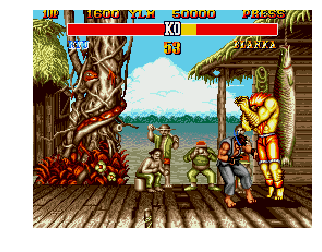

Total reward -29.0


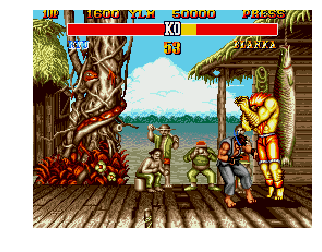

In [13]:
plt.figure(3)
plt.clf()
env.close()
saver = tf.train.Saver()
env = env = SF2Env(rom_path, 
                   'rvsb.state', 
                   scenario=scenario_name,
                   players=1,
                   use_restricted_actions=retro.Actions.DISCRETE)

with tf.Session() as sess:
    total_test_rewards = []
    
    # Load the model
    saver.restore(sess, model_path)
    
    for episode in range(1):
        total_rewards = 0
        
        state = env.reset()
        
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        state = state.flatten()
        
        
        
        print("****************************************************")
        print("EPISODE ", episode)
        
        t = 0
        while True:
            t += 1
            # Reshape the state
            state = state.reshape((1, state_size))
            # Get action from Q-network 
            # Estimate the Qs values state
            Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state})
            
            # Take the biggest Q value (= the best action)
            choice = np.argmax(Qs)
            action = possible_actions[choice]
            a_list = [0]*env.action_space.n
            a_list[choice] = 1
            
            #Perform the action and get the next_state, reward, and done information
            next_state, reward, done, _ = env.step(action)
            
            if t % 2 == 0:
                plt.imshow(env.render(mode='rgb_array'))
                plt.axis('off')
                display.clear_output(wait=True)
                display.display(plt.gcf())
            
            
            total_rewards += reward

            if done:
                print ("Total reward", total_rewards)
                total_test_rewards.append(total_rewards)
                break
                
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            next_state = next_state.flatten()
            state = next_state
            
    env.close()

In [ ]:
env.close()


In [ ]:
memory.buffer[0]

In [14]:
len(memory.buffer)

100000

In [15]:
import sys
sys.getsizeof(memory)

56

In [ ]:
env.close()

In [18]:
sys.getsizeof(memory.buffer)

825368

In [19]:
sys.getsizeof(' ')

50